In [1]:
import pandas as pd


df = pd.read_excel('output/IVF 2018 -2021 all time w reply.xlsx')
df['processed_text_str'] = df['stemmed'].apply(lambda v: v.strip("['']").split("', '")).apply(' '.join)
df[['processed_text_str', 'cleaned_text']]

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import normalize

vectorizer = CountVectorizer(max_df = 0.9, min_df=100, token_pattern = '\w+|\$[\d\.]+|\S+')

#df['processed_text_list'] = df['processed_text_rm_standard_sw'].strip("']['").split("', '")
tf = vectorizer.fit_transform(df['processed_text_str'])
# tf_feature_names tells us what word each column in the matrix represents
tf_feature_names = vectorizer.get_feature_names()
tf.shape


(7248, 181)

In [2]:
from sklearn.decomposition import LatentDirichletAllocation
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)
model = LatentDirichletAllocation(n_components=5, random_state=45) 
# fit data to model
model.fit(tf)
no_top_words = 10
display_topics(model, tf_feature_names, no_top_words)
def display_topics2(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)
topics_df = display_topics2(model, tf_feature_names, no_top_words)
topics_df

,Topic 0 words,Topic 1 words,Topic 2 words,Topic 3 words,Topic 4 words
0,ivf,get,like,women,want
1,fertil,caus,feel,birth,kid
2,hope,vaccin,women,health,babi
3,year,pregnant,know,treatment,peopl
4,treatment,covid,miscarriag,abort,adopt
5,day,make,woman,control,child
6,today,like,struggl,reproduct,coupl
7,week,peopl,day,men,famili
8,thank,think,say,care,mom
9,journey,got,thing,make,someon


In [4]:
import numpy as np

# create topic matrix
lda_output = model.fit_transform(tf)

# column names
topicnames = topics_df.columns

# index names
docnames = ["Doc" + str(i) for i in range(len(df))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
df_document_topic

,Topic 0 words,Topic 1 words,Topic 2 words,Topic 3 words,Topic 4 words
Doc0,0.02,0.65,0.16,0.02,0.15
Doc1,0.01,0.34,0.01,0.26,0.37
Doc2,0.49,0.02,0.32,0.02,0.15
Doc3,0.03,0.24,0.03,0.03,0.66
Doc4,0.03,0.03,0.03,0.46,0.43
...,...,...,...,...,...
Doc7243,0.38,0.07,0.07,0.42,0.07
Doc7244,0.28,0.04,0.60,0.04,0.04
Doc7245,0.54,0.05,0.05,0.31,0.05
Doc7246,0.79,0.02,0.02,0.02,0.15


In [5]:
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
df_document_topic['percentage_contribution'] = df_document_topic[['Topic 0 words', 'Topic 1 words', 'Topic 2 words', 'Topic 3 words', 'Topic 4 words']].values.max(1)

df_document_topic.reset_index(inplace=True)
df_sent_topic= pd.merge(df, df_document_topic, left_index=True, right_index=True)
df_sent_topic.drop('index', axis=1, inplace=True)
df_document_topic['percentage_contribution'] = df_document_topic[['Topic 0 words', 'Topic 1 words', 'Topic 2 words', 'Topic 3 words', 'Topic 4 words']].values.max(1)

df_document_topic.reset_index(inplace=True)
df_sent_topic= pd.merge(df, df_document_topic, left_index=True, right_index=True)
df_sent_topic.drop('index', axis=1, inplace=True)
df_sent_topic.tail()


,id,author_id,count_retweet,created_at,date,geo,geo_city,like_count,place_id,text,...,sentiment_score_rm_self_sw,processed_text_str,level_0,Topic 0 words,Topic 1 words,Topic 2 words,Topic 3 words,Topic 4 words,dominant_topic,percentage_contribution
7243,1058051915295137792,1464729936,0,2018-11-01T17:43:28.000Z,2018-11-01,"{'type': 'Feature', 'bbox': [-84.576827, 33.64...","Atlanta, GA",2,8173485c72e78ca5,"Here at #CTATL18 listening to Jessica Spencer,...",...,0.0000,ctatl listen jessica spencer md msc associ pro...,7243,0.38,0.07,0.07,0.42,0.07,3,0.42
7244,1058051913696964608,21435703,8,2018-11-01T17:43:28.000Z,2018-11-01,"{'type': 'Feature', 'bbox': [-111.979047, 33.3...","Tempe, AZ",11,7cb7440bcf83d464,Heartbreaking story of a Phoenix woman's strug...,...,-1.1588,heartbreak stori phoenix woman struggl inferti...,7244,0.28,0.04,0.60,0.04,0.04,2,0.60
7245,1058000367814930433,889254880916975617,1,2018-11-01T14:18:39.000Z,2018-11-01,"{'type': 'Feature', 'bbox': [-81.845887, 26.45...","San Carlos Park, FL",2,46bf69ae15f33611,My final stim meds were being delivered yester...,...,-0.5223,final stim med deliv yesterday miss driver cha...,7245,0.54,0.05,0.05,0.31,0.05,0,0.54
7246,1057998983967264768,889254880916975617,0,2018-11-01T14:13:09.000Z,2018-11-01,"{'type': 'Feature', 'bbox': [-87.634643, 24.39...","Florida, USA",0,4ec01c9dbc693497,I left all of my syringes in the bathroom at w...,...,0.4215,left syring bathroom work last night thank wor...,7246,0.79,0.02,0.02,0.02,0.15,0,0.79
7247,1057795525259472896,313441329,0,2018-11-01T00:44:40.000Z,2018-11-01,"{'type': 'Feature', 'bbox': [-83.353955, 32.04...","South Carolina, USA",3,6057f1e35bcc6c20,Thanks @WomensHealthMag for allowing my voice ...,...,-0.0363,thank allow voic heard bring awar keep dialogu...,7247,0.52,0.03,0.40,0.03,0.03,0,0.52


In [6]:
df_sent_topic.groupby("dominant_topic")['sentiment_score_rm_self_sw'].agg(['count', 'mean', 'median'])

,count,mean,median
dominant_topic,,,
0,2069,0.376342,0.2592
1,1387,-0.101843,0.0000
2,1437,0.093338,0.0212
3,1093,-0.068985,0.0000
4,1262,0.064426,0.0000


In [7]:
import matplotlib.pyplot as plt

topic0 = df_sent_topic[(df_sent_topic["dominant_topic"] == 0)]

topic0_p = topic0[topic0['sentiment_score_rm_self_sw'] > 0.5]
topic0_n = topic0[(topic0['sentiment_score_rm_self_sw'] > -0.5) & (topic0['sentiment_score_rm_self_sw'] < 0.5)]
topic0_ne = topic0[topic0['sentiment_score_rm_self_sw'] < -0.5]

topic1 = df_sent_topic[(df_sent_topic["dominant_topic"] == 1)]

topic1_p = topic1[topic1['sentiment_score_rm_self_sw'] > 0.5]
topic1_n = topic1[(topic1['sentiment_score_rm_self_sw'] > -0.5) & (topic1['sentiment_score_rm_self_sw'] < 0.5)]
topic1_ne = topic1[topic1['sentiment_score_rm_self_sw'] < -0.5]

topic2 = df_sent_topic[(df_sent_topic["dominant_topic"] == 2)]

topic2_p = topic2[topic2['sentiment_score_rm_self_sw'] > 0.5]
topic2_n = topic2[(topic2['sentiment_score_rm_self_sw'] > -0.5) & (topic2['sentiment_score_rm_self_sw'] < 0.5)]
topic2_ne = topic2[topic2['sentiment_score_rm_self_sw'] < -0.5]

topic3 = df_sent_topic[(df_sent_topic["dominant_topic"] == 3)]

topic3_p = topic3[topic3['sentiment_score_rm_self_sw'] > 0.5]
topic3_n = topic3[(topic3['sentiment_score_rm_self_sw'] > -0.5) & (topic3['sentiment_score_rm_self_sw'] < 0.5)]
topic3_ne = topic3[topic3['sentiment_score_rm_self_sw'] < -0.5]


topic4 = df_sent_topic[(df_sent_topic["dominant_topic"] == 2)]

topic4_p = topic4[topic4['sentiment_score_rm_self_sw'] > 0.5]
topic4_n = topic4[(topic4['sentiment_score_rm_self_sw'] > -0.5) & (topic4['sentiment_score_rm_self_sw'] < 0.5)]
topic4_ne = topic4[topic4['sentiment_score_rm_self_sw'] < -0.5]

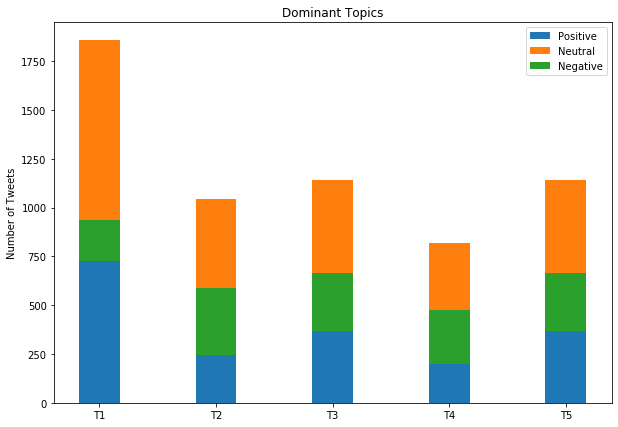

In [8]:
N = 5
 
Positive = (len(topic0_p), len(topic1_p), len(topic2_p), len(topic3_p), len(topic4_p))
Neutral = (len(topic0_n), len(topic1_n), len(topic2_n), len(topic3_n), len(topic4_n))
Negative = (len(topic0_ne), len(topic1_ne), len(topic2_ne), len(topic3_ne), len(topic4_ne))
# pStd = (2, 3, 4, 1, 2)
# nStd = (3, 5, 2, 3, 3)
# neStd = (3, 5, 2, 3, 3)

ind = np.arange(N)  
width = 0.35 
 
fig = plt.subplots(figsize =(10, 7))
p1 = plt.bar(ind, Positive, width)
p2 = plt.bar(ind, Neutral, width, bottom = Positive)
p3 = plt.bar(ind, Negative, width, bottom = Positive)

 
plt.ylabel('Number of Tweets')
plt.title('Dominant Topics')
plt.xticks(ind, ('T1', 'T2', 'T3', 'T4', 'T5'))
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0], p3[0]), ('Positive', 'Neutral', 'Negative'))
 
plt.show()